# Consensus LcL CENTRE.MSI.MI comparison with consensus LcL CENTRE
consensus Lcl 10kb resolution 30kb window size

In [1]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from xgboost import plot_importance
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
#from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from numpy import sort

In [2]:
def optimalparamsearch(com):
    com['distance'] =com['distance'].abs()
    com=com.sort_values('pair19')
    com=com.reset_index(drop=True)
    ''' function to do parameter search '''
    cv_names=com["CV"].unique()
    myCViterator = []
    for i in range(len(cv_names)):
        trainIndices = com[ com['CV']!=cv_names[i] ].index.values.astype(int)
        testIndices =  com[ com['CV']==cv_names[i] ].index.values.astype(int)
        myCViterator.append( (trainIndices, testIndices) )


    #run randomized search for optimal parameters

    X_train= com.drop(['gene_id1','gene_id','symbol38','symbol19','pair','pair19','label','CV'], axis=1).copy()
    y_train = com['label'].copy()
    model = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0)
    param_grid = {
            'max_depth': [4, 5, 6,8,10,12],
            'learning_rate': [0.1, 0.05, 0.01],
            'gamma': [0, 0.25, 1.0],
            'reg_lambda': [0, 1.0, 10.0],
            'n_estimators': [100,200,300,400,500],
            'colsample_bytree': [0.5,0.6,0.7,0.9],
            'subsample': [0.7, 0.9]
        }
    search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,scoring='f1', cv=myCViterator, n_jobs=12, refit=True)
    result = search.fit(X_train, y_train)
    print('est=%.3f, cfg=%s' % (result.best_score_, result.best_params_))
    return(result.best_score_, result.best_params_)

In [3]:
def trainOptParams(com, best_params, pathtomodel):
    X_train_xg= com.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
    y_train_xg = com['label'].copy()
    clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
    clf_xgb.fit(X_train_xg, y_train_xg)
    clf_xgb.save_model(pathtomodel)
    return(clf_xgb)

In [4]:
def makeFeatImpPlot(clf_xgb, sample, pathtopic):
    clf_xgb.get_booster().feature_names= ["CRUP-EP enhancer 1", "CRUP-EP enhancer 2", "CRUP-EP enhancer 3", "CRUP-EP enhancer 4",
                                     "CRUP-EP enhancer 5","CRUP-EP promoter 1","CRUP-EP promoter 2","CRUP-EP promoter 3",
                                     "CRUP-EP promoter 4","CRUP-EP promoter 5","CRUP-PP enhancer 1", "CRUP-PP enhancer 2", 
                                      "CRUP-PP enhancer 3", "CRUP-PP enhancer 4",
                                     "CRUP-PP enhancer 5","CRUP-PP promoter 1","CRUP-PP promoter 2","CRUP-PP promoter 3",
                                     "CRUP-PP promoter 4","CRUP-PP promoter 5","Genomic distance","CRUP correlation",
                                     "Wilcoxon tests combined","Regulatory distance\n enhancers",
                                      "Normalized Regulatory\n distance enhancers","Regulatory distance\n promoters",
                                      "Normalized Regulatory\n distance promoters", "RNA-seq", "Minimum Insulation", "Mean Switch Intensity"]

    fig1=plot_importance(clf_xgb,xlabel="number of times a feature appears in a tree",show_values=False,
                         title= "Feature importance CENTRE.MI.MSI " + sample,ylabel=None,max_num_features=10)
    pyplot.show()
    fig1.figure.tight_layout()
    fig1.figure.savefig(pathtopic, 
                 dpi=300,orientation='landscape',format='png',facecolor='white')
    return(0)

In [9]:
def CVF1results(com, com1, best_params, best_params1):

    cv_names=com["CV"].unique()
    d = dict(tuple(com.groupby('CV')))
    d1 = dict(tuple(com1.groupby('CV')))
    result_all_xgboost={}
    result_all_tf={}
    result_cv_xg=[]
    result_cv_tf=[]
    for i in range(len(cv_names)):
        cv_test=cv_names[i]
        cv_train=[x for k,x in enumerate(cv_names) if k!=i]
        X_test_xg = d[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_test_xg = d[cv_test]['label'].copy()
        train_xg=pd.concat({k: d[k] for k in cv_train})
        X_train_xg= train_xg.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_train_xg = train_xg['label'].copy()
        clf_xgb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params)
        clf_xgb.fit(X_train_xg, y_train_xg)
        pred_s = clf_xgb.predict_proba(X_test_xg)
        lr_probs =pred_s[:, 1]
        yhat = clf_xgb.predict(X_test_xg)
        result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_xg})
        result_cv_xg.append(f1_score(result_cv['true_label'], result_cv['pred_label']))
        result_all_xgboost[cv_test]=result_cv
        
        X_test_tf = d1[cv_test].drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_test_tf = d1[cv_test]['label'].copy()
        train_tf=pd.concat({k: d1[k] for k in cv_train})
        X_train_tf= train_tf.drop(['gene_id1', 'gene_id', 'symbol38', 'symbol19', 'pair', 'pair19', 'label', 'CV'], axis=1).copy()
        y_train_tf = train_tf['label'].copy()
        clf_gb = xgb.XGBClassifier(objective = "binary:logistic",scale_pos_weight=5,random_state=0,**best_params1)
        clf_gb.fit(X_train_tf, y_train_tf)
        pred_s = clf_gb.predict_proba(X_test_tf)
        lr_probs =pred_s[:, 1]
        yhat = clf_gb.predict(X_test_tf)
        result_cv = pd.DataFrame({'pred_prob':lr_probs,'pred_label': yhat,'true_label':y_test_tf})
        result_cv_tf.append(f1_score(result_cv['true_label'], result_cv['pred_label']))
        result_all_tf[cv_test]=result_cv



    results_xg=pd.concat(result_all_xgboost)
    
    lr_precision_xg, lr_recall_xg, _ = precision_recall_curve(results_xg['true_label'], results_xg['pred_prob'])
    lr_f1_xg, lr_auc_xg = f1_score(results_xg['true_label'], results_xg['pred_label']), auc(lr_recall_xg, lr_precision_xg)
    print('xgboost HiC 12 fold CV:auc=%.3f' % lr_auc_xg)
    print(lr_f1_xg)
    print(result_cv_xg)


    results_tf=pd.concat(result_all_tf)
    lr_precision_tf, lr_recall_tf, _ = precision_recall_curve(results_tf['true_label'], results_tf['pred_prob'])
    lr_f1_tf, lr_auc_tf = f1_score(results_tf['true_label'], results_tf['pred_label'], average = None), auc(lr_recall_tf, lr_precision_tf)
    print('CENTRE 12 fold CV: auc=%.3f' % lr_auc_tf)
    print(lr_f1_tf)
    print(result_cv_tf)
    dist_precision, dist_recall, _=precision_recall_curve(com['label'],1/abs(com['distance']))
    dist_auc = auc(dist_recall, dist_precision)
    print('Distance:auc=%.3f' % (dist_auc))
    ##1st f1 scores of CENTRE.MSI.MI
    ##2nd f1 scores of CENTRE
    return(lr_f1_xg, lr_f1_tf, result_cv_xg, result_cv_tf, lr_precision_xg, lr_recall_xg, lr_precision_tf, lr_recall_tf)

In [6]:
### This is where the script starts

##General paths and suffixes
suffixMIMSI = ".MI.MSI.v38.10kb30kb.csv"
suffixBENGI = "-Benchmark.v38.txt"
rootMIMSI = "/project/CRUP_scores/CENTRE_HiC/Training/BENGI_MSI_MI_datasets/"
rootBENGI = "/project/CRUP_scores/toSara/BENGI_processed_datasets/"

(370486, 38)
                           pair         gene_id1             gene_id  \
0  EH38E0078724_ENSG00000000938  ENSG00000000938   ENSG00000000938.8   
1  EH38E0078724_ENSG00000009780  ENSG00000009780  ENSG00000009780.11   
2  EH38E0078724_ENSG00000117758  ENSG00000117758   ENSG00000117758.9   
3  EH38E0078724_ENSG00000126698  ENSG00000126698   ENSG00000126698.6   
4  EH38E0078724_ENSG00000126705  ENSG00000126705   ENSG00000126705.9   

       symbol38      symbol19                           pair19  label     CV  \
0  EH38E0078724  EH37E0078724   EH37E0078724_ENSG00000000938.8      0  cv-11   
1  EH38E0078724  EH37E0078724  EH37E0078724_ENSG00000009780.11      0  cv-11   
2  EH38E0078724  EH37E0078724   EH37E0078724_ENSG00000117758.9      0  cv-11   
3  EH38E0078724  EH37E0078724   EH37E0078724_ENSG00000126698.6      0   cv-0   
4  EH38E0078724  EH37E0078724   EH37E0078724_ENSG00000126705.9      0  cv-11   

   EP_prob_enh.1  EP_prob_enh.2  ...  distance  cor_CRUP  combined_tests 

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:33:56] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


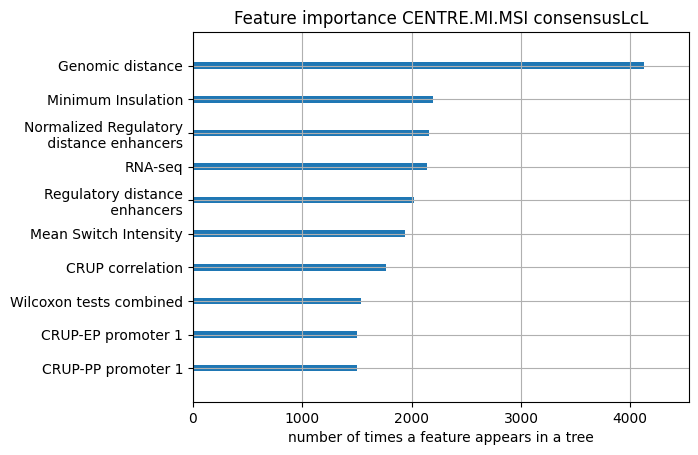

/home/lopez_s/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:34:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


xgboost HiC 12 fold CV:auc=0.559
0.5351680733896023
[0.48962346215981106, 0.5517727994355266, 0.5534086766314255, 0.557109190887667, 0.4872669992123917, 0.5203361344537816, 0.5575884300400766, 0.5508186091749068, 0.572737686139748, 0.5176866928691747, 0.5258774538964901, 0.5675207756232686]
CENTRE 12 fold CV: auc=0.565
[0.92595207 0.52845256]
[0.47702318015453443, 0.5334536159975943, 0.5367786937222574, 0.5441000399095385, 0.5145290047897818, 0.5029577261578415, 0.5533469745688395, 0.5540098199672668, 0.5680111265646731, 0.5075361427253153, 0.5222208543641511, 0.5512159174649963]
Distance:auc=0.197


In [13]:
sample = "consensusLcL"
consensusLcLMSIMI = pd.read_csv(rootMIMSI+sample+suffixMIMSI, 
                 header=0, sep=',')
print (consensusLcLMSIMI.shape)
consensusLcLMSIMI = consensusLcLMSIMI.drop_duplicates('pair19')
print(consensusLcLMSIMI.head())
consensusLcL = pd.read_csv("/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/consensus_LCLs.txt", 
                 header=0, sep='\t')
print (consensusLcL.shape)
print(consensusLcL.head())
##Parameter search
com=consensusLcLMSIMI.fillna(0)
com1=consensusLcL.fillna(0)
best_score, best_params = optimalparamsearch(com)
#best_score1, best_params1 = optimalparamsearch(com1)
best_params1 = {"colsample_bytree": 0.7, 
                "gamma" : 1.0, "learning_rate" : 0.1,
                "max_depth" : 5, "n_estimators" : 300, "reg_lambda" : 0, "subsample" : 0.9}
##Train with opt parameters and feature importance
centreMSIMImodel = trainOptParams(com, best_params, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_HiC_classifiers/"+sample+"10kb_model.txt")
makeFeatImpPlot(centreMSIMImodel, sample, "/project/CRUP_scores/CENTRE_HiC/Training/"+sample+"10kb.png")

centremodel = trainOptParams(com1, best_params1, "/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_classifiers/"+sample+"_model.txt")


f1_CENTREMIMSI, f1_CENTRE, f1_CENTREMIMSICV, f1_CENTRECV, CENTREMIMSIREC, CENTREMIMSIPRE, CENTREREC, CENTREPRE= CVF1results(com, com1, best_params, best_params1)


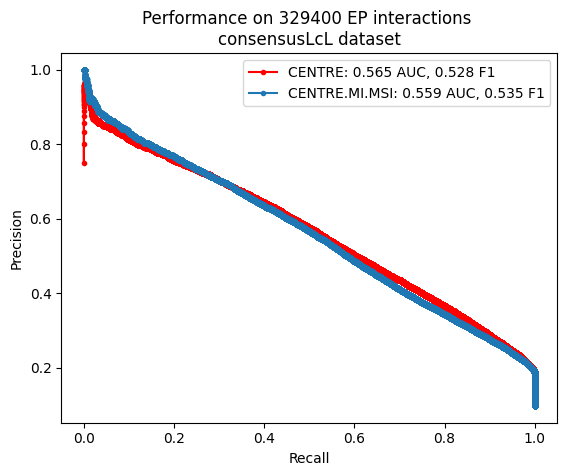

In [15]:


#no_skill = sum(results_xg['true_label']) /len(results_xg.index)#
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(CENTREPRE, CENTREREC, marker='.', label='CENTRE: 0.565 AUC, 0.528 F1',color='red')
pyplot.plot(CENTREMIMSIPRE, CENTREMIMSIREC, marker='.', label='CENTRE.MI.MSI: 0.559 AUC, 0.535 F1')
#pyplot.plot(dist_recall,dist_precision, marker='.',color='black' ,label='Distance 0.34',markersize=1)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
#pyplot.text(0.4, 0.5, "AUC=0.70")
pyplot.title('Performance on 329400 EP interactions \nconsensusLcL dataset')
# show the legend
pyplot.legend()
# show the plot
fig1 =pyplot.gcf()
pyplot.show()
fig1.savefig('/project/CRUP_scores/CENTRE_HiC/Training/CENTRE_final_training/consensusLcL_10kbperformance.png', 
             dpi=300,orientation='landscape',format='png',facecolor='white')